In [0]:
import torch
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy

class UJIDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None, target_transform = None, download = False):
        self.root = root
        dir_path = self.root + '/UJIndoorLoc'
        zip_path = self.root + '/uji_uil.zip'
        dataset_training_file = dir_path + '/trainingData.csv'
        dataset_validation_file = dir_path + '/validationData.csv'
        # Load independent variables (WAPs values)
        if train:
            dataset_file = dataset_training_file
        else:
            dataset_file = dataset_validation_file
        file = open(dataset_file, 'r')
        # Load labels
        label = file.readline()
        label = label.split(',')
        # Load independent variables
        file_load = np.loadtxt(file, dtype = 'd', delimiter = ',', skiprows = 1)
        #file_load_label = np.loadtxt(file, delimiter = ',')
        #data = np.genfromtxt(file, dtype = float, delimiter = ',', names = True)
        # RSSI values
        self.x = file_load[:, 0 : 520]
        # Load dependent variables
        self.y = file_load[:, 520 : 524]
        # Divide labels into x and y
        self.x_label = label[0 : 520]
        self.x_label = np.concatenate([self.x_label, label[524: 529]])
        self.y_label = label[520 : 524]
        # Scaling independent variables to be within 0 and 1
        self.x[self.x == 100] = -110      # WAP not detected (weaker than -104 dBm)
        self.x = self.x + 110             # Convert into positive values
        self.x = self.x / 110             # Scaling into [0, 1]
        # Space ID, Relative Position, User ID, Phone ID and Timestamp respectively
        self.x = np.concatenate([self.x, file_load[:, 524 : 529]], axis = 1)
        file.close()
        # Reduce the number of dependent variables by combining building number and floor into one variable: area
        area = self.y[:, 3] * 5 + self.y[:, 2]
        self.y = np.column_stack((self.y, area))
    def to_tensor(self):
        self.x = torch.from_numpy(self.x).double()
        self.y = torch.from_numpy(self.y).double()
    def nan_to_zero(self):
        self.x = np.nan_to_num(self.x)
    def groupby_user(self):
        xy = np.column_stack((self.x.numpy(), self.y.numpy()))
        num_user = len(set(self.x[:, 522].numpy()))
        self.user_list = []
        for i in range(1, num_user + 1):
            criterion = (xy[:, 522] == i)
            self.user_list.append(xy[criterion])
    def groupby_scenario(self):
        # 1st dim: user id, 2nd dim: scenario id
        index_separator = []
        if not hasattr(self, 'user_list'):
            self.groupby_user()
        self.scenario_list = []
        self.scenario_list_x = []
        for i in range(len(self.user_list)):
            # Sort by timestamp
            user_temp = []
            user_temp_x = []
            index_separator = []
            sort_index = np.argsort(self.user_list[i][:, 524])
            self.user_list[i] = self.user_list[i][sort_index]
            for j in range(1, len(self.user_list[i])):
                # Detect time intervals greater than 10s
                if self.user_list[i][j, 524] - self.user_list[i][j - 1, 524] > 10:
                    index_separator.append(j)
            for j in range(len(index_separator)):
                if j == 0:
                    user_temp.append(self.user_list[i][0 : index_separator[0], :])
                    user_temp_x.append(self.user_list[i][0 : index_separator[0], 0 : 520])
                    j += 1
                user_temp.append(self.user_list[i][index_separator[j - 1] : index_separator[j], :])
                user_temp_x.append(self.user_list[i][index_separator[j - 1] : index_separator[j], 0 : 520])
                if j == len(index_separator) - 1:
                    user_temp.append(self.user_list[i][index_separator[j] : , :])
                    user_temp_x.append(self.user_list[i][index_separator[j] :, 0 : 520])
                #print('self.scenario_list[0]: ', self.scenario_list[0])
            self.scenario_list.append(user_temp)
            self.scenario_list_x.append(user_temp_x)
    def sortby_time(self):
        self.xy_sortedby_time = np.column_stack((self.x.numpy(), self.y.numpy()))
        sort_index = np.argsort(self.xy_sortedby_time[:, 524])
        self.xy_sortedby_time = self.xy_sortedby_time[sort_index]
    def time_to_tensor(self):
        # Given xy_sortedby_time
        if hasattr(self, 'xy_sortedby_time'):
            for i in range(len(self.xy_sortedby_time)):
                if type(self.xy_sortedby_time[0]) == np.ndarray:
                    self.xy_sortedby_time = torch.from_numpy(self.xy_sortedby_time).double()
    def time_to_image_list(self, row_num):
        if hasattr(self, 'xy_sortedby_time'):
            self.user_x_image_list = []
            self.user_y_image_list = []
            temp_x = torch.DoubleTensor(row_num, 520)
            temp_y = torch.DoubleTensor(row_num, 4)
            for i in range(len(self.xy_sortedby_time)):
                #torch.cat(self.user_stack[prev_row_num : i, 0 : 520], out = temp)
                temp_x = self.xy_sortedby_time[i, 0 : 520].repeat(row_num, 1)
                temp_y = self.xy_sortedby_time[i, 525 : 529].repeat(row_num, 1)
                self.user_x_image_list.append(temp_x)
                self.user_y_image_list.append(temp_y)          
    def user_list_to_tensor(self):
        # Given user_list
        if hasattr(self, 'user_list'):
            for i in range(len(self.user_list)):
                if type(self.user_list[i][0]) == np.ndarray:
                    self.user_list[i] = torch.from_numpy(self.user_list[i]).double()
    def user_list_to_stack(self):
        # Given user_list
        if hasattr(self, 'user_list'):
            self.user_stack = torch.DoubleTensor(len(self.x), 530)
            torch.cat(self.user_list, out = self.user_stack)
    def user_stack_to_image_list(self, row_num):
        # Given user_stack
        if hasattr(self, 'user_stack'):
            # self.user_x_image = torch.DoubleTensor(int(len(self.x) / row_num), 520)
            self.user_x_image_list = []
            self.user_y_image_list = []
            temp_x = torch.DoubleTensor(row_num, 520)
            temp_y = torch.DoubleTensor(row_num, 4)
            prev_row_num = 0
            for i in range(row_num, len(self.x), 1):
                #torch.cat(self.user_stack[prev_row_num : i, 0 : 520], out = temp)
                temp_x = self.user_stack[prev_row_num : i, 0 : 520]
                temp_y = self.user_stack[prev_row_num : i, 525 : 529]
                self.user_x_image_list.append(temp_x)
                self.user_y_image_list.append(temp_y)
                prev_row_num += 1
    # Make scenario_list into one tensor
    def scenario_list_to_stack(self):
        # Given scenario_list
        if hasattr(self, 'scenario_list'):
            self.scenario_stack = torch.DoubleTensor()
            for i in range(len(dataset_train.scenario_list)):
                for j in range(len(dataset_train.scenario_list[i])):
                    self.scenario_stack = torch.cat((self.scenario_stack, dataset_train.scenario_list[i][j]))
            print(len(self.scenario_stack))
    def scenario_list_x_reshape(self):
        # Given scenario_list_x
        if hasattr(self, 'scenario_list_x'):
            for i in range(len(dataset_train.scenario_list_x)):
                for j in range(len(dataset_train.scenario_list_x[i])):
                    # Reshape the vector X into matrix of size (20 x 26)
                    if type(dataset_train.scenario_list_x[i][j][0]) == np.ndarray:
                        dataset_train.scenario_list_x[i][j] = torch.from_numpy(dataset_train.scenario_list_x[i][j]).double()
                    dataset_train.scenario_list_x[i][j] = dataset_train.scenario_list_x[i][j].view(dataset_train.scenario_list_x[i][j].size(0), 20, 26)
    def scenario_list_to_tensor(self):
        # Given scenario_list_x
        if hasattr(self, 'scenario_list_x'):
            for i in range(len(dataset_train.scenario_list_x)):
                for j in range(len(dataset_train.scenario_list_x[i])):
                    if type(dataset_train.scenario_list_x[i][j][0]) == np.ndarray:
                        dataset_train.scenario_list_x[i][j] = torch.from_numpy(dataset_train.scenario_list_x[i][j]).double()
        # Given scenario_list
        if hasattr(self, 'scenario_list'):
            for i in range(len(dataset_train.scenario_list)):
                for j in range(len(dataset_train.scenario_list[i])):
                    if type(dataset_train.scenario_list[i][j][0]) == np.ndarray:
                        dataset_train.scenario_list[i][j] = torch.from_numpy(dataset_train.scenario_list[i][j]).double()
    def set_scenario(self, user, segment):
        self.user = user
        self.segment = segment
    def set_label(self, label):
        # 1 for longitude, 2 for latitude, 3 for floor, 4 for building, 5 for area
        self.label = label
    # Return the target instance
    def __getitem__(self, scenario):
        # self.user_x_image_list and self.user_y_image_list should be set already prior to call __getitem__
        if hasattr(self, 'user_x_image_list') and hasattr(self, 'user_y_image_list'):
            return self.user_x_image_list[scenario], self.user_y_image_list[scenario]
            #if hasattr(self, 'label'):
            #    return self.user_stack[instance, 0 : 520], self.user_stack[instance, 524 + self.label]
    # Return the number of instances (the number of rows)
    def __len__(self):
        if hasattr(self, 'user_x_image_list'):
            return len(self.user_x_image_list)

In [0]:
#from google.colab import auth
#auth.authenticate_user()

#from google.colab import drive
#drive.mount('/content/gdrive')

We load the training dataset (`trainingData.csv`) and the test dataset (`validationData.csv`)

In [0]:
# Load training dataset
#dataset_train = UJIDataset('./gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/data', train = True)
dataset_train = UJIDataset('./data', train = True)
dataset_train.nan_to_zero()
dataset_train.to_tensor()
# Use only a part of trainingData.csv as a training set and the leftover as a validating set
training_size = int(0.8 * len(dataset_train.x))
# Load test dataset
#dataset_test = UJIDataset('./gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/data', train = False)
dataset_test = UJIDataset('./data', train = False)
dataset_test.nan_to_zero()
dataset_test.to_tensor()

The class `DelegateElectArea` is based on PCA.
It will be used to predict the building and the floor with the given input of RSSI values.

In [0]:
class DelegateElectArea(torch.nn.Module):
    def __init__(self):
        pass
    def train(self, x, y, delegate_num = 1):
        self.x_train = x
        self.y_train = y
        self.delegate_num = delegate_num
    # In this case, x_dim = 520 and y_range is within 0 and 15 (area)
    def naive_delegate(self, x_dim, y_range):
        # Construct weight_map of size y_range by x_dim
        self.weight_map = torch.zeros([y_range, x_dim], dtype = torch.float64)
        # Prevent divide-by-zero
        y_range_count = torch.ones([y_range])
        if self.delegate_num is 1:
            self.x_train_delegate_index = torch.argmax(self.x_train, dim = 1)
            # Update weight_map
            # Weight is 1
            for i in range(0, self.x_train_delegate_index.size()[0]):
                self.weight_map[int(self.y_train[i]), int(self.x_train_delegate_index[i])] += 1
                y_range_count[int(self.y_train[i])] += 1
            self.weight_map = self.weight_map / y_range_count[:, None]
        else:
            # Take all features that have non-zero values as delegates with corresponding weight (based on value)
            # self.x_train_delegate = self.x_train, no need to make a duplicate
            # Update weight_map
            # Weight is the RSSI value
            for i in range(0, self.x_train.size()[0]):
                self.weight_map[int(self.y_train[i]), :] += self.x_train[i, :]
                y_range_count[int(self.y_train[i])] += 1
            self.weight_map = self.weight_map / y_range_count[:, None]
    def softmax_delegate(self, x_dim, y_range):
        # Construct weight_map of size y_range by x_dim
        self.weight_map = torch.zeros([y_range, x_dim], dtype = torch.float64)
        # Prevent divide-by-zero
        y_range_count = torch.ones([y_range])
        softmax_row = torch.nn.Softmax(dim = 1)
        softmax_log = torch.nn.LogSoftmax(dim = 1)
        # Take all features that have non-zero values as delegates with corresponding weight (based on value)
        # self.x_train_delegate = self.x_train, no need to make a duplicate
        # Update weight_map
        # Applying softmax function on RSSI values for each instance
        for i in range(0, self.x_train.size()[0]):
            self.weight_map[int(self.y_train[i]), :] += (self.x_train[i, :])
            y_range_count[int(self.y_train[i])] += 1
        self.weight_map = self.weight_map / y_range_count[:, None]
        self.weight_map = softmax_row(self.weight_map)
    def elect(self, x_input_instance):
        # Calculate matrix multiplication of weight_map with x_input
        candidate = torch.matmul(self.weight_map.float(), (x_input_instance * 110).float())
        # Return the largest weight element's index from the candidate vector
        return torch.argmax(candidate).item()
    def evaluate(self, x_validate, y_validate):
        error_building = []
        error_floor = []
        error_area = []
        for i in range(0, x_validate.size()[0]):
            prediction = self.elect(x_validate[i, :])
            if (prediction % 5) != y_validate[i, 2]:
                error_floor.append(i)
            if int(prediction / 5) != y_validate[i, 3]:
                error_building.append(i)
            if prediction != y_validate[i, 4]:
                error_area.append(i)
        error_rate_building = len(error_building) / x_validate.size()[0]
        error_rate_floor = len(error_floor) / x_validate.size()[0]
        error_rate_area = len(error_area) / x_validate.size()[0]
        print('error_rate_building: ', error_rate_building)
        print('error_rate_floor: ', error_rate_floor)
        print('error_rate_area: ', error_rate_area)

In [6]:
area_predictor = DelegateElectArea()
area_predictor.train(dataset_train.x[0 : training_size, 0 : 520], dataset_train.y[0 : training_size, 4], delegate_num = 0)
area_predictor.softmax_delegate(x_dim = 520, y_range = 15)
# Cross validation
area_predictor.evaluate(dataset_train.x[training_size : , 0 : 520], dataset_train.y[training_size : , :])

error_rate_building:  0.0025075225677031092
error_rate_floor:  0.20386158475426278
error_rate_area:  0.20386158475426278


The function `euclidean_distance` takes two coordinates and returns the distance between the two.

In [0]:
# Calculate Euclidean distance (unit: meter) between two coordinates in EPSG:3857 
def euclidean_distance(latitude_1, longitude_1, latitude_2, longitude_2):
    return torch.sqrt((latitude_1 - latitude_2)**2 + (longitude_1 - longitude_2)**2)

The class `DelegateElectLocation` is based on PCA.
It will be used to predict the location (latitude and longitude coordinates) with the given input of RSSI values.

In [0]:
class DelegateElectLocation():
    def __init(self):
        pass
    def train(self, x, y, delegate_num = 1):
        self.x = x
        self.y = y
        self.delegate_num = delegate_num
    def naive_delegate(self):
        # Take the leftmost, rightmost, lowermost and uppermost grid coordinates from the training data
        self.left_bound = self.y[torch.argmin(self.y[:, 0]).item(), 0].item()
        self.right_bound = self.y[torch.argmax(self.y[:, 0]).item(), 0].item()
        self.lower_bound = self.y[torch.argmin(self.y[:, 1]).item(), 1].item()
        self.upper_bound = self.y[torch.argmax(self.y[:, 1]).item(), 1].item()
        # Scale the coordinates to natural number of which the unit becomes (0.1m)
        column_num = int((right_bound - left_bound) * 10) + 1
        row_num = int((upper_bound - lower_bound) * 10) + 1
        # Construct the coordinates mapping matrix
        self.coordinate_map = torch.zeros([row_num, column_num], dtype = torch.float64)
        # Construct the correlation matrix of (longitude by RSSI values) and (latitude by RSSI values)
        self.longitude_weight_map = torch.zeros([column_num, self.x.size()[1]], dtype = torch.float64)
        self.latitude_weight_map = torch.zeros([row_num, self.x.size()[1]], dtype = torch.float64)
        # Prevent divide-by-zero
        longitude_count = torch.ones([column_num])
        latitude_count = torch.ones([row_num])
        # If we take only one representative (largest) element of each independent instance
        if self.delegate_num is 1:
            delegate_index = torch.argmax(self.x, dim = 1)
            for i in range(delegate_index.size()[0]):
                self.longitude_weight_map[int((self.y[i, 0] - self.left_bound) * 10), int(delegate_index[i])] += 1
                self.latitude_weight_map[int((self.y[i, 1] - self.lower_bound) * 10), int(delegate_index[i])] += 1
                longitude_count[int((self.y[i, 0] - self.left_bound) * 10)] += 1
                latitude_count[int((self.y[i, 1] - self.lower_bound) * 10)] += 1
                self.coordinate_map[int((self.y[i, 1] - self.lower_bound) * 10), int((self.y[i, 0] - self.left_bound) * 10)] += 1
        # If we take all elements of each independent instance with their corresponding weights
        else:
            for i in range(self.x.size()[0]):
                self.longitude_weight_map[int((self.y[i, 0] - self.left_bound) * 10), :] += self.x[i, :]
                self.latitude_weight_map[int((self.y[i, 1] - self.lower_bound) * 10), :] += self.x[i, :]
                longitude_count[int((self.y[i, 0] - self.left_bound) * 10)] += 1
                latitude_count[int((self.y[i, 1] - self.lower_bound) * 10)] += 1
                self.coordinate_map[int((self.y[i, 1] - self.lower_bound) * 10), int((self.y[i, 0] - self.left_bound) * 10)] += 1
        # Take means of each row of weight maps with corresponding counts
        self.longitude_weight_map /= longitude_count[:, None]
        self.latitude_weight_map /= latitude_count[:, None]
    # Same as naive_delegate function except that softmax_delegate function applies softmax function to the output weight maps
    def softmax_delegate(self):
        self.left_bound = self.y[torch.argmin(self.y[:, 0]).item(), 0].item()
        self.right_bound = self.y[torch.argmax(self.y[:, 0]).item(), 0].item()
        self.lower_bound = self.y[torch.argmin(self.y[:, 1]).item(), 1].item()
        self.upper_bound = self.y[torch.argmax(self.y[:, 1]).item(), 1].item()
        column_num = int((self.right_bound - self.left_bound) * 10) + 1
        row_num = int((self.upper_bound - self.lower_bound) * 10) + 1
        self.coordinate_map = torch.zeros([row_num, column_num], dtype = torch.float64)
        self.longitude_weight_map = torch.zeros([column_num, self.x.size()[1]], dtype = torch.float64)
        self.latitude_weight_map = torch.zeros([row_num, self.x.size()[1]], dtype = torch.float64)
        # Prevent divide-by-zero
        longitude_count = torch.ones([column_num])
        latitude_count = torch.ones([row_num])
        softmax_row = torch.nn.Softmax(dim = 1)
        softmax_log = torch.nn.LogSoftmax(dim = 1)
        # Take all features that have non-zero values as delegates with corresponding weight (based on value)
        # self.x_train_delegate = self.x_train, no need to make a duplicate
        # Update weight_map
        for i in range(self.x.size()[0]):
            self.longitude_weight_map[int((self.y[i, 0] - self.left_bound) * 10), :] += self.x[i, :]
            self.latitude_weight_map[int((self.y[i, 1] - self.lower_bound) * 10), :] += self.x[i, :]
            longitude_count[int((self.y[i, 0] - self.left_bound) * 10)] += 1
            latitude_count[int((self.y[i, 1] - self.lower_bound) * 10)] += 1
            self.coordinate_map[int((self.y[i, 1] - self.lower_bound) * 10), int((self.y[i, 0] - self.left_bound) * 10)] += 1
        self.longitude_weight_map /= longitude_count[:, None]
        self.latitude_weight_map /= latitude_count[:, None]
        # Applying softmax function on RSSI values for each instance
        self.longitude_weight_map = softmax_row(self.longitude_weight_map)
        self.latitude_weight_map = softmax_row(self.latitude_weight_map)
    def elect(self, x_input_instance):
        # Calculate matrix multiplication of weight_map with transpose of x_input
        longitude_candidate = torch.matmul(self.longitude_weight_map.float(), (x_input_instance * 110).float())
        latitude_candidate = torch.matmul(self.latitude_weight_map.float(), (x_input_instance * 110).float())
        # Return the largest weight element's index from the candidate vector
        return torch.argmax(latitude_candidate).item(), torch.argmax(longitude_candidate).item()
    def evaluate(self, x_validate, y_validate):
        error_distance = []
        for i in range(0, x_validate.size()[0]):
            latitude_prediction, longitude_prediction = self.elect(x_validate[i, :])
            # Rescale back to the original pseudo-mercator coordinates
            latitude_prediction = latitude_prediction / 10 + self.lower_bound
            longitude_prediction = longitude_prediction / 10 + self.left_bound
            # Push back the errors based on euclidean distance (unit: meter) for each prediction
            error_distance.append(euclidean_distance(y_validate[i, 1], y_validate[i, 0], latitude_prediction, longitude_prediction))
        # Take mean, max, min of all errors of distance
        error_mean_distance = torch.mean(torch.stack(error_distance)).item()
        error_max_distance = torch.max(torch.stack(error_distance)).item()
        error_min_distance = torch.min(torch.stack(error_distance)).item()
        error_std_distance = torch.std(torch.stack(error_distance)).item()
        error_var_distance = torch.var(torch.stack(error_distance)).item()
        print('error_mean_distance: ', error_mean_distance)
        print('error_max_distance: ', error_max_distance)
        print('error_min_distance: ', error_min_distance)
        print('error_std_distance: ', error_std_distance)
        print('error_var_distance: ', error_var_distance)
        #print('error_distance: ', error_distance)

In [9]:
location_predictor = DelegateElectLocation()
location_predictor.train(dataset_train.x[0 : training_size, 0 : 520], dataset_train.y[0 : training_size, :], delegate_num = 0)
location_predictor.softmax_delegate()
# Cross validation
location_predictor.evaluate(dataset_train.x[training_size :, 0 : 520], dataset_train.y[training_size :, :])

error_mean_distance:  15.78639655306903
error_max_distance:  252.51236187178125
error_min_distance:  0.026719010738527255
error_std_distance:  17.45874235974617
error_var_distance:  304.80768478399534


The real test with `validationData.csv` is as follows.

In [10]:
area_predictor = DelegateElectArea()
area_predictor.train(dataset_train.x[:, 0 : 520], dataset_train.y[:, 4], delegate_num = 0)
area_predictor.softmax_delegate(x_dim = 520, y_range = 15)
# Test (real validation)
area_predictor.evaluate(dataset_test.x[:, 0 : 520], dataset_test.y)

error_rate_building:  0.0009009009009009009
error_rate_floor:  0.16216216216216217
error_rate_area:  0.16216216216216217


In [11]:
location_predictor = DelegateElectLocation()
location_predictor.train(dataset_train.x[:, 0 : 520], dataset_train.y, delegate_num = 0)
location_predictor.softmax_delegate()
# Test (real validation)
location_predictor.evaluate(dataset_test.x[:, 0: 520], dataset_test.y)

error_mean_distance:  13.260879564745712
error_max_distance:  79.45591488746821
error_min_distance:  0.02170610805435014
error_std_distance:  10.430297393623706
error_var_distance:  108.79110371943345


The training dataset is grouped by User ID and then grouped by scenario (time segment) for each user

In [0]:
dataset_train.groupby_user()
dataset_train.groupby_scenario()
dataset_train.user_list_to_tensor()
dataset_train.user_list_to_stack()
dataset_train.user_stack_to_image_list(8)
#dataset_train.scenario_list_to_tensor()
#dataset_train.scenario_list_to_stack()
dataset_test.sortby_time()
dataset_test.time_to_tensor()
dataset_test.time_to_image_list(8)

In [13]:
num_user = len(set(dataset_train.x[:, 522].numpy()))
print("We have ", num_user, " users in training dataset")
for i in range(num_user):
    print("\tUser #", i + 1, ": ", len(dataset_train.user_list[i][:, 522]) / len(dataset_train.x) * 100, "%")

We have  18  users in training dataset
	User # 1 :  13.728932584269662 %
	User # 2 :  5.467495987158909 %
	User # 3 :  0.9630818619582664 %
	User # 4 :  1.8760032102728732 %
	User # 5 :  3.0597913322632424 %
	User # 6 :  4.915730337078652 %
	User # 7 :  6.9371990369181376 %
	User # 8 :  2.5431380417335476 %
	User # 9 :  5.347110754414125 %
	User # 10 :  4.579654895666132 %
	User # 11 :  22.652487961476726 %
	User # 12 :  2.192014446227929 %
	User # 13 :  4.218499197431782 %
	User # 14 :  8.00561797752809 %
	User # 15 :  2.4979935794542536 %
	User # 16 :  5.1765650080256815 %
	User # 17 :  3.631621187800963 %
	User # 18 :  2.207062600321027 %


In [14]:
print("For each user, we have following number of scenarios: \n")
total_num = 0
for i in range(num_user):
    print("\tUser #", i + 1, ": ", len(dataset_train.scenario_list[i]), "scenario(s)")
    total_num += len(dataset_train.scenario_list[i])
print("\nTotal ", total_num, "scenario(s)")

For each user, we have following number of scenarios: 

	User # 1 :  274 scenario(s)
	User # 2 :  115 scenario(s)
	User # 3 :  21 scenario(s)
	User # 4 :  58 scenario(s)
	User # 5 :  78 scenario(s)
	User # 6 :  82 scenario(s)
	User # 7 :  141 scenario(s)
	User # 8 :  56 scenario(s)
	User # 9 :  107 scenario(s)
	User # 10 :  92 scenario(s)
	User # 11 :  459 scenario(s)
	User # 12 :  47 scenario(s)
	User # 13 :  84 scenario(s)
	User # 14 :  165 scenario(s)
	User # 15 :  69 scenario(s)
	User # 16 :  100 scenario(s)
	User # 17 :  85 scenario(s)
	User # 18 :  42 scenario(s)

Total  2075 scenario(s)


In [15]:
print("For each user, we have following distribution of instances per scenario: \n")
total_instances = []
for i in range(num_user):
    instances = []
    for j in range(len(dataset_train.scenario_list[i])):
        instances.append(len(dataset_train.scenario_list[i][j]))
        total_instances.append(len(dataset_train.scenario_list[i][j]))
    print("\tUser #", i + 1, ": ")
    print("\t\tminimum number of instances: ", np.min(instances))
    print("\t\tmean number of instances: ", np.mean(instances))
    print("\t\tmaximum number of instances: ", np.max(instances))
print("\ntotal mean number of instances: ", np.mean(total_instances))

For each user, we have following distribution of instances per scenario: 

	User # 1 : 
		minimum number of instances:  1
		mean number of instances:  10.025547445255475
		maximum number of instances:  26
	User # 2 : 
		minimum number of instances:  1
		mean number of instances:  9.565217391304348
		maximum number of instances:  27
	User # 3 : 
		minimum number of instances:  2
		mean number of instances:  9.619047619047619
		maximum number of instances:  10
	User # 4 : 
		minimum number of instances:  1
		mean number of instances:  6.620689655172414
		maximum number of instances:  10
	User # 5 : 
		minimum number of instances:  1
		mean number of instances:  7.948717948717949
		maximum number of instances:  10
	User # 6 : 
		minimum number of instances:  10
		mean number of instances:  12.073170731707316
		maximum number of instances:  80
	User # 7 : 
		minimum number of instances:  1
		mean number of instances:  9.879432624113475
		maximum number of instances:  20
	User # 8 : 
		mini

In [16]:
print("For each user, we have following time segment information: \n")
for i in range(num_user):
    time_interval = []
    for j in range(len(dataset_train.scenario_list[i])):
        min_time = np.min(dataset_train.scenario_list[i][j][:, 524])
        max_time = np.max(dataset_train.scenario_list[i][j][:, 524])
        time_interval.append(max_time - min_time)
    print("\tUser #", i + 1, ": ")
    print("\t\tminimum time interval: ", np.min(time_interval))
    print("\t\tmean time interval: ", np.mean(time_interval))
    print("\t\tmaximum time interval: ", np.max(time_interval))

For each user, we have following time segment information: 

	User # 1 : 
		minimum time interval:  0.0
		mean time interval:  3.7883211678832116
		maximum time interval:  32.0
	User # 2 : 
		minimum time interval:  0.0
		mean time interval:  12.443478260869565
		maximum time interval:  60.0
	User # 3 : 
		minimum time interval:  1.0
		mean time interval:  8.857142857142858
		maximum time interval:  10.0
	User # 4 : 
		minimum time interval:  0.0
		mean time interval:  7.103448275862069
		maximum time interval:  17.0
	User # 5 : 
		minimum time interval:  0.0
		mean time interval:  24.012820512820515
		maximum time interval:  33.0
	User # 6 : 
		minimum time interval:  1.0
		mean time interval:  8.21951219512195
		maximum time interval:  112.0
	User # 7 : 
		minimum time interval:  0.0
		mean time interval:  13.74468085106383
		maximum time interval:  36.0
	User # 8 : 
		minimum time interval:  0.0
		mean time interval:  12.607142857142858
		maximum time interval:  16.0
	User # 9 : 
		


Visualizing the first sample time segment of User # 1 on 3-D plot




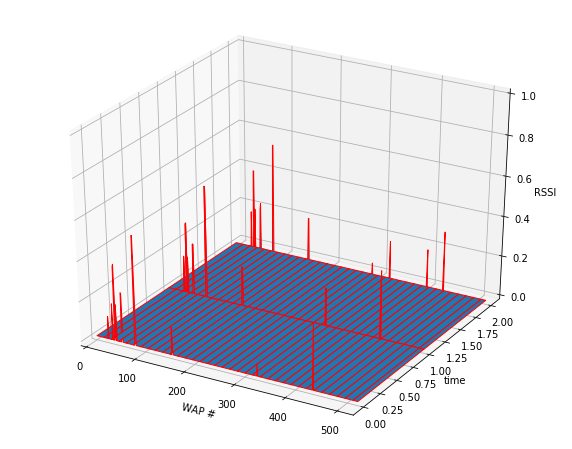

In [17]:
fig = plt.figure(figsize = (10, 8))
axes = fig.add_subplot(111, projection = "3d")
# Time domain on y_axis
min_time = np.min(dataset_train.scenario_list[0][0][:, 524])
max_time = np.max(dataset_train.scenario_list[0][0][:, 524])
y_axis = np.arange(max_time - min_time)
# X index on x_axis
x_axis = np.linspace(0, 520, 520)
# meshgrid
x_grid, y_grid = np.meshgrid(x_axis, y_axis)
# X values on z_axis
z_grid = np.zeros((len(y_axis), len(x_axis)))
# points on each axis
sequence_length = len(dataset_train.scenario_list[0][0])
add_counter = torch.zeros([len(y_axis)])
for i in range(len(y_axis)):
    for j in range(i, sequence_length):
        if dataset_train.scenario_list[0][0][j, 524] - min_time == i:
            #print("i: ", i, "j: ", j)
            z_grid[i] += dataset_train.scenario_list[0][0][j, 0 : 520]
            add_counter[i] += 1
add_counter[add_counter == 0] += 1
z_grid /= add_counter[:, None].numpy()
print("\nVisualizing the first sample time segment of User # 1 on 3-D plot\n\n")
axes.plot_surface(x_grid, y_grid, z_grid, rstride = 1, cstride = 15, shade = False, lw = 1, edgecolors = 'r')
axes.set_zlim(0, 1)
axes.set_xlim(0, 520)
axes.set_xlabel("WAP #")
axes.set_ylabel("time")
axes.set_zlabel("RSSI")
plt.show()

For each time segment(scenario), vector X of size (1 x 520) is reshaped to size (20 x 26)

The following network is CNN of which input is a sequence group of instances of size (8 x 520).

The Single Task Time-series CNNs

In [0]:
class BuildingCNNSequence(torch.nn.Module):
    input_size = [8, 520]
    kernel_size_1 = [5, 5]
    kernel_size_2 = [3, 3]
    mp_out_size = [2, 2]
    conv_out_channel_1 = 8
    conv_out_channel_2 = 8
    def __init__(self):
        super(BuildingCNNSequence, self).__init__()
        # Activation map size
        # 4 x 516
        conv_map_1 = (np.array(self.input_size) - np.array(self.kernel_size_1)) / 1 + 1
        # 2 x 514
        #conv_map_2 = (conv_map_1 - np.array(self.kernel_size_2)) / 1 + 1
        # 2 x 257
        mp_out = conv_map_1 // np.array(self.mp_out_size)
        # Fully connected layers for each target
        fcl_out_share = 520
        fcl_out_building_1 = 52
        fcl_out_building_2 = 3

        # convolutional network output size of 4112 to feed FCL
        self.conv_output_size = int(mp_out[0] * mp_out[1] * self.conv_out_channel_2)
        self.convolve = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = self.conv_out_channel_1, kernel_size = self.kernel_size_1),
            # Number of parameters to learn: 1 * 5 * 5 * 8 = 200
            torch.nn.LeakyReLU(),
            #torch.nn.MaxPool2d(self.mp_size_1, return_indices = True),
            
            #torch.nn.Conv2d(in_channels = self.conv_out_channel_1, out_channels = self.conv_out_channel_2, kernel_size = self.kernel_size_2),
            # Number of parameters to learn: 8 * 3 * 3 * 8 = 576
            #torch.nn.ReLU(),
            torch.nn.MaxPool2d(self.mp_out_size, return_indices = False),
        )
        self.classify_building = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_building_1),
            torch.nn.Linear(fcl_out_building_1, fcl_out_building_2),
            # Activation function
            torch.nn.LogSoftmax(dim = 1),
        )
    # For scenario based (time-series) training
    def forward(self, x):
        x = self.convolve(x)
        # Flatten x for Fully Connected Layers
        x = x.view(-1, self.conv_output_size)
        # Building
        x = self.classify_building(x)
        return x

In [21]:
cnnBuilding = BuildingCNNSequence()
if torch.cuda.is_available():
  cnnBuilding = torch.nn.DataParallel(cnnBuilding)
  cnnBuilding = cnnBuilding.cuda()
cnnBuilding.double()
print(cnnBuilding)

DataParallel(
  (module): BuildingCNNSequence(
    (convolve): Sequential(
      (0): Conv2d(1, 8, kernel_size=[5, 5], stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    )
    (classify_building): Sequential(
      (0): Linear(in_features=4128, out_features=520, bias=True)
      (1): Linear(in_features=520, out_features=52, bias=True)
      (2): Linear(in_features=52, out_features=3, bias=True)
      (3): LogSoftmax()
    )
  )
)


In [22]:
for param in cnnBuilding.parameters():
    print(param.size())

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([520, 4128])
torch.Size([520])
torch.Size([52, 520])
torch.Size([52])
torch.Size([3, 52])
torch.Size([3])


In [0]:
mtl_learning_rate = 0.2
mtl_multiclass_criterion = torch.nn.NLLLoss()
mtl_building_optimizer = torch.optim.Adam(cnnBuilding.parameters(), mtl_learning_rate)

In [0]:
# Sampler
# We actuall do not need sampler as we have done sampling based on time segment (scenario)
training_size = int(0.8 * len(dataset_train.user_x_image_list))
indices = list(range(len(dataset_train.user_x_image_list)))
train_indices, validate_indices = indices[: training_size], indices[training_size : ]
train_sampler = torch.utils.data.sampler.SequentialSampler(train_indices)
validate_sampler = torch.utils.data.sampler.SequentialSampler(validate_indices)

In [0]:
train_dataloader_part = torch.utils.data.DataLoader(dataset_train, sampler = train_sampler)
validate_dataloader = torch.utils.data.DataLoader(dataset_train, sampler = validate_sampler)
train_dataloader_all = torch.utils.data.DataLoader(dataset_train)
test_dataloader = torch.utils.data.DataLoader(dataset_test)

In [0]:
#building_state_dict = torch.load('./gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/BuildingCNN.pth')
building_state_dict = torch.load('./BuildingCNN.pth')

In [0]:
load_building = False
if cnnBuilding.load_state_dict(building_state_dict):
    load_building = True

In [0]:
if not load_building:
    epochs = 50
    torch.manual_seed(1)
    # For early stopping
    num_epochs_stop = 3
    min_loss_val = np.Inf
    num_epochs_no_improve = 0

    for epoch in range(epochs):
        loss_total = 0
        loss_running = 0.0
        building_hit = 0
        total_size = len(dataset_train.user_x_image_list)
        # Training of 80% of the trainingData
        for i, (X, Y) in enumerate(train_dataloader_all):
            X = torch.autograd.Variable(X[None, ...])
            Y = torch.autograd.Variable(Y[None, ...])
            if torch.cuda.is_available():
              X = X.cuda()
              Y = Y.cuda()
            # Forward pass
            mtl_building_optimizer.zero_grad()
            # Building
            out = cnnBuilding(X)
            # Backward pass
            y = Y.squeeze()[3, 3].unsqueeze(0).long()
            loss = mtl_multiclass_criterion(out, y)
            loss.backward()
            
            # Optimize
            mtl_building_optimizer.step()
            
            # Print statistics
            loss_running += loss.item()
            if i % 1000  == 999:
                print('[epoch: %d / %d, i: %5d] loss: %.3f' % 
                    (epoch + 1, epochs, i + 1, loss_running / 1000))
                loss_running = 0.0
        # Validating of the left 20% of the trainingData
        correct = []
        for i, (X, Y) in enumerate(validate_dataloader):
            X = torch.autograd.Variable(X[None, ...])
            if torch.cuda.is_available():
              X = X.cuda()
              Y = Y.cuda()
            #Forward pass
            out = cnnBuilding(X)
            pred = torch.argmax(out).double()
            y = Y.squeeze()[3, 3].unsqueeze(0).double()
            if i == 3000:
                print('pred:', pred)
                print('y:', y)
            if pred == y:
                correct.append(i)
        building_validate_accuracy = len(correct) / len(validate_dataloader)
        print('\tbuilding validate accuracy: %.5f' %
              (building_validate_accuracy))
            #if pred_4 == Y.squeeze()[3, 3].unsqueeze(0).double():
            #    correct_4.append(i)
    print('Finished training')

In [0]:
#torch.save(cnnBuilding.state_dict(), './gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/BuildingCNN.pth')

In [30]:
# Real Test
correct = []
for i, (X, Y) in enumerate(test_dataloader):
    X = torch.autograd.Variable(X[None, ...])
    if torch.cuda.is_available():
      X = X.cuda()
      Y = Y.cuda()
    #Forward pass
    out = cnnBuilding(X)
    pred = torch.argmax(out).double()
    y = Y.squeeze()[3, 3].unsqueeze(0).double()
    if pred == y:
        correct.append(i)
building_test_accuracy = len(correct) / len(test_dataloader)
print('\tbuilding test accuracy: %.5f' %
      (building_test_accuracy))

	building test accuracy: 1.00000


In [0]:
class FloorCNNSequence(torch.nn.Module):
    input_size = [8, 520]
    kernel_size_1 = [5, 5]
    kernel_size_2 = [3, 3]
    mp_out_size = [2, 2]
    conv_out_channel_1 = 8
    conv_out_channel_2 = 8
    def __init__(self):
        super(FloorCNNSequence, self).__init__()
        # Activation map size
        # 4 x 516
        conv_map_1 = (np.array(self.input_size) - np.array(self.kernel_size_1)) / 1 + 1
        # 2 x 514
        #conv_map_2 = (conv_map_1 - np.array(self.kernel_size_2)) / 1 + 1
        # 2 x 257
        mp_out = conv_map_1 // np.array(self.mp_out_size)
        # Fully connected layers for each target
        fcl_out_share = 520
        fcl_out_floor_1 = 52
        fcl_out_floor_2 = 5

        # convolutional network output size of 4112 to feed FCL
        self.conv_output_size = int(mp_out[0] * mp_out[1] * self.conv_out_channel_2)
        self.convolve = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = self.conv_out_channel_1, kernel_size = self.kernel_size_1),
            # Number of parameters to learn: 1 * 5 * 5 * 8 = 200
            torch.nn.LeakyReLU(),
            #torch.nn.MaxPool2d(self.mp_size_1, return_indices = True),
            
            #torch.nn.Conv2d(in_channels = self.conv_out_channel_1, out_channels = self.conv_out_channel_2, kernel_size = self.kernel_size_2),
            # Number of parameters to learn: 8 * 3 * 3 * 8 = 576
            #torch.nn.ReLU(),
            torch.nn.MaxPool2d(self.mp_out_size, return_indices = False),
        )
        self.classify_floor = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_floor_1),
            torch.nn.Linear(fcl_out_floor_1, fcl_out_floor_2),
            # Activation function
            torch.nn.LogSoftmax(dim = 1),
        )
    # For scenario based (time-series) training
    def forward(self, x):
        x = self.convolve(x)
        # Flatten x for Fully Connected Layers
        x = x.view(-1, self.conv_output_size)
        # Floor
        x = self.classify_floor(x)
        return x

In [32]:
cnnFloor = FloorCNNSequence()
if torch.cuda.is_available():
  cnnFloor = torch.nn.DataParallel(cnnFloor)
  cnnFloor = cnnFloor.cuda()
cnnFloor.double()
print(cnnFloor)

DataParallel(
  (module): FloorCNNSequence(
    (convolve): Sequential(
      (0): Conv2d(1, 8, kernel_size=[5, 5], stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    )
    (classify_floor): Sequential(
      (0): Linear(in_features=4128, out_features=520, bias=True)
      (1): Linear(in_features=520, out_features=52, bias=True)
      (2): Linear(in_features=52, out_features=5, bias=True)
      (3): LogSoftmax()
    )
  )
)


In [33]:
for param in cnnFloor.parameters():
    print(param.size())

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([520, 4128])
torch.Size([520])
torch.Size([52, 520])
torch.Size([52])
torch.Size([5, 52])
torch.Size([5])


In [0]:
mtl_learning_rate = 0.05
mtl_multiclass_criterion = torch.nn.NLLLoss()
mtl_floor_optimizer = torch.optim.Adam(cnnFloor.parameters(), mtl_learning_rate)

In [0]:
# Sampler
# We actuall do not need sampler as we have done sampling based on time segment (scenario)
training_size = int(0.8 * len(dataset_train.user_x_image_list))
indices = list(range(len(dataset_train.user_x_image_list)))
train_indices, validate_indices = indices[: training_size], indices[training_size : ]
train_sampler = torch.utils.data.sampler.SequentialSampler(train_indices)
validate_sampler = torch.utils.data.sampler.SequentialSampler(validate_indices)

In [0]:
train_dataloader_part = torch.utils.data.DataLoader(dataset_train, sampler = train_sampler)
validate_dataloader = torch.utils.data.DataLoader(dataset_train, sampler = validate_sampler)
train_dataloader_all = torch.utils.data.DataLoader(dataset_train)
test_dataloader = torch.utils.data.DataLoader(dataset_test)

In [0]:
#floor_state_dict = torch.load('./gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/FloorCNN.pth')
floor_state_dict = torch.load('./FloorCNN.pth')

In [0]:
load_floor = False
if cnnFloor.load_state_dict(floor_state_dict):
    load_floor = True

In [0]:
if not load_floor:
    epochs = 300
    torch.manual_seed(1)
    # For early stopping
    num_epochs_stop = 3
    min_loss_val = np.Inf
    num_epochs_no_improve = 0

    for epoch in range(epochs):
        loss_total = 0
        loss_running = 0.0
        building_hit = 0
        # Training of 80% of the trainingData
        for i, (X, Y) in enumerate(train_dataloader_all):
            X = torch.autograd.Variable(X[None, ...])
            Y = torch.autograd.Variable(Y[None, ...])
            if torch.cuda.is_available():
              X = X.cuda()
              Y = Y.cuda()
            # Forward pass
            mtl_floor_optimizer.zero_grad()
            # Building
            out = cnnFloor(X)
            # Backward pass
            y = Y.squeeze()[3, 2].unsqueeze(0).long()
            loss = mtl_multiclass_criterion(out, y)
            loss.backward()
            
            # Optimize
            mtl_floor_optimizer.step()
            
            # Print statistics
            loss_running += loss.item()
            if i % 1000  == 999:
                print('[epoch: %d / %d, i: %5d] loss: %.3f' % 
                    (epoch + 1, epochs, i + 1, loss_running / 1000))
                loss_running = 0.0
        # Validating of the left 20% of the trainingData
        correct = []
        for i, (X, Y) in enumerate(validate_dataloader):
            X = torch.autograd.Variable(X[None, ...])
            if torch.cuda.is_available():
              X = X.cuda()
              Y = Y.cuda()
            #Forward pass
            out = cnnFloor(X)
            pred = torch.argmax(out).double()
            y = Y.squeeze()[3, 2].unsqueeze(0).double()
            if i == 3000:
                print('pred:', pred)
                print('y:', y)
            if pred == y:
                correct.append(i)
        floor_validate_accuracy = len(correct) / len(validate_dataloader)
        print('\tfloor validate accuracy: %.5f' %
              (floor_validate_accuracy))
            #if pred_4 == Y.squeeze()[3, 3].unsqueeze(0).double():
            #    correct_4.append(i)
    print('Finished training')

In [0]:
#torch.save(cnnFloor.state_dict(), './gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/FloorCNN.pth')

In [41]:
# Real Test
correct = []
for i, (X, Y) in enumerate(test_dataloader):
    X = torch.autograd.Variable(X[None, ...])
    if torch.cuda.is_available():
      X = X.cuda()
      Y = Y.cuda()
    #Forward pass
    out = cnnFloor(X)
    pred = torch.argmax(out).double()
    y = Y.squeeze()[3, 2].unsqueeze(0).double()
    if pred == y:
        correct.append(i)
floor_test_accuracy = len(correct) / len(test_dataloader)
print('\tfloor test accuracy: %.5f' %
      (floor_test_accuracy))

	floor test accuracy: 0.87477


Longitude and Latitude CNNs need more improvement

In [0]:
class LongitudeCNNSequence(torch.nn.Module):
    input_size = [8, 520]
    kernel_size_1 = [5, 5]
    kernel_size_2 = [3, 3]
    mp_out_size = [2, 2]
    conv_out_channel_1 = 2
    conv_out_channel_2 = 4
    def __init__(self):
        super(LongitudeCNNSequence, self).__init__()
        # Activation map size
        # 4 x 516
        conv_map_1 = (np.array(self.input_size) - np.array(self.kernel_size_1)) / 1 + 1
        # 2 x 514
        conv_map_2 = (conv_map_1 - np.array(self.kernel_size_2)) / 1 + 1
        # 2 x 257
        #mp_out = conv_map_2 // np.array(self.mp_out_size)
        # Fully connected layers for each target
        fcl_out_share = 520
        fcl_out_latlong_1 = 52
        fcl_out_latlong_2 = 1
        #fcl_out_latlong_3 = 1

        # convolutional network output size of 4112 to feed FCL
        self.conv_output_size = int(conv_map_2[0] * conv_map_2[1] * self.conv_out_channel_2)
        self.convolve = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = self.conv_out_channel_1, kernel_size = self.kernel_size_1),
            torch.nn.BatchNorm2d(2),
            # Number of parameters to learn: 1 * 5 * 5 * 8 = 200
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p = 0.1),
            #torch.nn.MaxPool2d(self.mp_size_1, return_indices = True),
            
            torch.nn.Conv2d(in_channels = self.conv_out_channel_1, out_channels = self.conv_out_channel_2, kernel_size = self.kernel_size_2),
            torch.nn.BatchNorm2d(4),
            # Number of parameters to learn: 8 * 3 * 3 * 8 = 576
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p = 0.1)
            #torch.nn.MaxPool2d(self.mp_out_size, return_indices = False),
        )
        self.regress_long = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_latlong_1),
            torch.nn.Linear(fcl_out_latlong_1, fcl_out_latlong_2),
            #torch.nn.Linear(fcl_out_latlong_2, fcl_out_latlong_3),
            # Activation function
            #torch.nn.LogSigmoid(),
        )
    # For scenario based (time-series) training
    def forward(self, x):
        x = self.convolve(x)
        # Flatten x for Fully Connected Layers
        x = x.view(-1, self.conv_output_size)
        # Floor
        x = self.regress_long(x)
        return x

In [0]:
cnnLongitude = LongitudeCNNSequence()
if torch.cuda.is_available():
  cnnLongitude = torch.nn.DataParallel(cnnLongitude)
  cnnLongitude = cnnLongitude.cuda()
cnnLongitude.double()
print(cnnLongitude)

In [0]:
for param in cnnLongitude.parameters():
    print(param.size())

In [0]:
mtl_learning_rate = 0.01
mtl_regression_criterion = torch.nn.MSELoss()
mtl_long_optimizer = torch.optim.Adam(cnnLongitude.parameters(), mtl_learning_rate)

In [0]:
# Sampler
# We actuall do not need sampler as we have done sampling based on time segment (scenario)
training_size = int(0.8 * len(dataset_train.user_x_image_list))
indices = list(range(len(dataset_train.user_x_image_list)))
train_indices, validate_indices = indices[: training_size], indices[training_size : ]
train_sampler = torch.utils.data.sampler.SequentialSampler(train_indices)
validate_sampler = torch.utils.data.sampler.SequentialSampler(validate_indices)

In [0]:
train_dataloader_part = torch.utils.data.DataLoader(dataset_train, sampler = train_sampler)
validate_dataloader = torch.utils.data.DataLoader(dataset_train, sampler = validate_sampler)
train_dataloader_all = torch.utils.data.DataLoader(dataset_train)
test_dataloader = torch.utils.data.DataLoader(dataset_test)

In [0]:
#longitude_state_dict = torch.load('./gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/LongitudeCNN.pth')

In [0]:
#cnnLongitude.load_state_dict(longitude_state_dict)

In [0]:
epochs = 150
torch.manual_seed(1)
# For early stopping
num_epochs_stop = 3
min_loss_val = np.Inf
num_epochs_no_improve = 0

for epoch in range(epochs):
    loss_total = 0
    loss_running = 0.0
    building_hit = 0
    total_size = len(dataset_train.user_x_image_list)
    # Training of 80% of the trainingData
    for i, (X, Y) in enumerate(train_dataloader_all):
        X = torch.autograd.Variable(X[None, ...])
        Y = torch.autograd.Variable(Y[None, ...])
        if torch.cuda.is_available():
          X = X.cuda()
          Y = Y.cuda()
        # Forward pass
        mtl_long_optimizer.zero_grad()
        # Building
        out = cnnLongitude(X).squeeze(0)
        # Backward pass
        y = Y.squeeze()[3, 0].unsqueeze(0).double()
        loss = torch.sqrt(mtl_regression_criterion(out, y))
        loss.backward()
        
        # Optimize
        mtl_long_optimizer.step()
        
        # Print statistics
        loss_running += loss.item()
        if i % 1000  == 999:
            print('[epoch: %d / %d, i: %5d] loss: %.3f' % 
                 (epoch + 1, epochs, i + 1, loss_running / 1000))
            loss_running = 0.0
    # Validating of the left 20% of the trainingData
    distance = []
    for i, (X, Y) in enumerate(validate_dataloader):
        X = torch.autograd.Variable(X[None, ...])
        if torch.cuda.is_available():
          X = X.cuda()
          Y = Y.cuda()
        #Forward pass
        out = cnnLongitude(X).squeeze(0)
        pred = out
        y = Y.squeeze()[3, 0].unsqueeze(0).double()
        if i == 3000:
            print('pred:', pred)
            print('y:', y)
        if torch.cuda.is_available():
            distance.append(euclidean_distance(pred.cuda(), 0, y.cuda(), 0))
        else:
            distance.append(euclidean_distance(pred, 0, y, 0))
    distance_validate_mean_error = torch.mean(torch.stack(distance)).item()
    distance_validate_min_error = torch.min(torch.stack(distance)).item()
    distance_validate_max_error = torch.max(torch.stack(distance)).item()
    distance_validate_std_error = torch.std(torch.stack(distance)).item()
    distance_validate_var_error = torch.var(torch.stack(distance)).item()
    print('epoch [%2d / %2d, i: %5d],\n mean distance: %.5f, min distance: %.5f, max distance: %.5f, std distance: %.5f, var distance: %.5f' % 
          (epoch + 1, epochs, i, distance_validate_mean_error, distance_validate_min_error, distance_validate_max_error, distance_validate_std_error, distance_validate_var_error))

print('Finished training')

In [0]:
#torch.save(cnnLongitude.state_dict(), './gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/LongitudeCNN.pth')

In [0]:
# Real Test
distance = []
for i, (X, Y) in enumerate(test_dataloader):
    X = torch.autograd.Variable(X[None, ...])
    if torch.cuda.is_available():
      X = X.cuda()
      Y = Y.cuda()
    #Forward pass
    out = cnnLongitude(X).squeeze(0)
    pred = torch.argmax(out).double()
    y = Y.squeeze()[3, 0].unsqueeze(0).double()
    if torch.cuda.is_available():
        distance.append(euclidean_distance(pred.cuda(), 0, y.cuda(), 0))
    else:
        distance.append(euclidean_distance(pred, 0, y, 0))
    distance_test_mean_error = torch.mean(torch.stack(distance)).item()
    distance_test_min_error = torch.min(torch.stack(distance)).item()
    distance_test_max_error = torch.max(torch.stack(distance)).item()
    distance_test_std_error = torch.std(torch.stack(distance)).item()
    distance_test_var_error = torch.var(torch.stack(distance)).item()
print('test:\n mean distance: %.5f, min distance: %.5f, max distance: %.5f, std distance: %.5f, var distance: %.5f' % 
    (distance_test_mean_error, distance_test_min_error, distance_test_max_error, distance_test_std_error, distance_test_var_error))

In [0]:
class LatitudeCNNSequence(torch.nn.Module):
    input_size = [8, 520]
    kernel_size_1 = [5, 5]
    kernel_size_2 = [3, 3]
    mp_out_size = [2, 2]
    conv_out_channel_1 = 2
    conv_out_channel_2 = 4
    def __init__(self):
        super(LatitudeCNNSequence, self).__init__()
        # Activation map size
        # 4 x 516
        conv_map_1 = (np.array(self.input_size) - np.array(self.kernel_size_1)) / 1 + 1
        # 2 x 514
        conv_map_2 = (conv_map_1 - np.array(self.kernel_size_2)) / 1 + 1
        # 2 x 257
        #mp_out = conv_map_2 // np.array(self.mp_out_size)
        # Fully connected layers for each target
        fcl_out_share = 520
        fcl_out_latlong_1 = 52
        fcl_out_latlong_2 = 1
        #fcl_out_latlong_3 = 1

        # convolutional network output size of 4112 to feed FCL
        self.conv_output_size = int(conv_map_2[0] * conv_map_2[1] * self.conv_out_channel_2)
        self.convolve = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = self.conv_out_channel_1, kernel_size = self.kernel_size_1),
            torch.nn.BatchNorm2d(2),
            # Number of parameters to learn: 1 * 5 * 5 * 8 = 200
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p = 0.1),
            #torch.nn.MaxPool2d(self.mp_size_1, return_indices = True),
            
            torch.nn.Conv2d(in_channels = self.conv_out_channel_1, out_channels = self.conv_out_channel_2, kernel_size = self.kernel_size_2),
            torch.nn.BatchNorm2d(4),
            # Number of parameters to learn: 8 * 3 * 3 * 8 = 576
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p = 0.1)
            #torch.nn.MaxPool2d(self.mp_out_size, return_indices = False),
        )
        self.regress_lat = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_latlong_1),
            torch.nn.Linear(fcl_out_latlong_1, fcl_out_latlong_2),
            #torch.nn.Linear(fcl_out_latlong_2, fcl_out_latlong_3),
            # Activation function
            #torch.nn.LogSigmoid(),
        )
    # For scenario based (time-series) training
    def forward(self, x):
        x = self.convolve(x)
        # Flatten x for Fully Connected Layers
        x = x.view(-1, self.conv_output_size)
        # Floor
        x = self.regress_lat(x)
        return x

In [0]:
cnnLatitude = LatitudeCNNSequence()
if torch.cuda.is_available():
  cnnLatitude = torch.nn.DataParallel(cnnLatitude)
  cnnLatitude = cnnLatitude.cuda()
cnnLatitude.double()
print(cnnLatitude)

In [0]:
for param in cnnLatitude.parameters():
    print(param.size())

In [0]:
mtl_learning_rate = 0.001
mtl_regression_criterion = torch.nn.MSELoss()
mtl_lat_optimizer = torch.optim.Adam(cnnLatitude.parameters(), mtl_learning_rate)

In [0]:
# Sampler
# We actuall do not need sampler as we have done sampling based on time segment (scenario)
training_size = int(0.8 * len(dataset_train.user_x_image_list))
indices = list(range(len(dataset_train.user_x_image_list)))
train_indices, validate_indices = indices[: training_size], indices[training_size : ]
train_sampler = torch.utils.data.sampler.SequentialSampler(train_indices)
validate_sampler = torch.utils.data.sampler.SequentialSampler(validate_indices)

In [0]:
train_dataloader_part = torch.utils.data.DataLoader(dataset_train, sampler = train_sampler)
validate_dataloader = torch.utils.data.DataLoader(dataset_train, sampler = validate_sampler)
train_dataloader_all = torch.utils.data.DataLoader(dataset_train)
test_dataloader = torch.utils.data.DataLoader(dataset_test)

In [0]:
epochs = 200
torch.manual_seed(1)
# For early stopping
num_epochs_stop = 3
min_loss_val = np.Inf
num_epochs_no_improve = 0

for epoch in range(epochs):
    loss_total = 0
    loss_running = 0.0
    building_hit = 0
    total_size = len(dataset_train.user_x_image_list)
    # Training of 80% of the trainingData
    for i, (X, Y) in enumerate(train_dataloader_all):
        X = torch.autograd.Variable(X[None, ...])
        Y = torch.autograd.Variable(Y[None, ...])
        if torch.cuda.is_available():
          X = X.cuda()
          Y = Y.cuda()
        # Forward pass
        mtl_lat_optimizer.zero_grad()
        # Building
        out = cnnLatitude(X).squeeze(0)
        # Backward pass
        y = Y.squeeze()[3, 1].unsqueeze(0).double()
        loss = torch.sqrt(mtl_regression_criterion(out, y))
        loss.backward()
        
        # Optimize
        mtl_lat_optimizer.step()
        
        # Print statistics
        loss_running += loss.item()
        if i % 1000  == 999:
            print('[epoch: %d / %d, i: %5d] loss: %.3f' % 
                 (epoch + 1, epochs, i + 1, loss_running / 1000))
            loss_running = 0.0
    # Validating of the left 20% of the trainingData
    distance = []
    for i, (X, Y) in enumerate(validate_dataloader):
        X = torch.autograd.Variable(X[None, ...])
        if torch.cuda.is_available():
          X = X.cuda()
          Y = Y.cuda()
        #Forward pass
        out = cnnLatitude(X).squeeze(0)
        pred = out
        y = Y.squeeze()[3, 1].unsqueeze(0).double()
        if i == 3000:
            print('pred:', pred)
            print('y:', y)
        if torch.cuda.is_available():
            distance.append(euclidean_distance(pred.cuda(), 0, y.cuda(), 0))
        else:
            distance.append(euclidean_distance(pred, 0, y, 0))
    distance_validate_mean_error = torch.mean(torch.stack(distance)).item()
    distance_validate_min_error = torch.min(torch.stack(distance)).item()
    distance_validate_max_error = torch.max(torch.stack(distance)).item()
    distance_validate_std_error = torch.std(torch.stack(distance)).item()
    distance_validate_var_error = torch.var(torch.stack(distance)).item()
    print('epoch [%2d / %2d, i: %5d],\n mean distance: %.5f, min distance: %.5f, max distance: %.5f, std distance: %.5f, var distance: %.5f' % 
          (epoch + 1, epochs, i, distance_validate_mean_error, distance_validate_min_error, distance_validate_max_error, distance_validate_std_error, distance_validate_var_error))

print('Finished training')

In [0]:
#torch.save(cnnLatitude.state_dict(), './gdrive/My Drive/Colab Notebooks/Indoor_Localization_Wifi_Fingerprinting/notebook/LatitudeCNN.pth')

In [0]:
# Real Test
distance = []
for i, (X, Y) in enumerate(test_dataloader):
    X = torch.autograd.Variable(X[None, ...])
    if torch.cuda.is_available():
      X = X.cuda()
      Y = Y.cuda()
    #Forward pass
    out = cnnLatitude(X).squeeze(0)
    pred = torch.argmax(out).double()
    y = Y.squeeze()[3, 0].unsqueeze(0).double()
    if torch.cuda.is_available():
        distance.append(euclidean_distance(pred.cuda(), 0, y.cuda(), 0))
    else:
        distance.append(euclidean_distance(pred, 0, y, 0))
    distance_test_mean_error = torch.mean(torch.stack(distance)).item()
    distance_test_min_error = torch.min(torch.stack(distance)).item()
    distance_test_max_error = torch.max(torch.stack(distance)).item()
    distance_test_std_error = torch.std(torch.stack(distance)).item()
    distance_test_var_error = torch.var(torch.stack(distance)).item()
    print('test:\n mean distance: %.5f, min distance: %.5f, max distance: %.5f, std distance: %.5f, var distance: %.5f' % 
          (distance_test_mean_error, distance_test_min_error, distance_test_max_error, distance_test_std_error, distance_test_var_error))

The Multi Task Time-series CNN does not work

In [0]:
class MultiTaskCNNSequence(torch.nn.Module):
    input_size = [8, 520]
    kernel_size_1 = [5, 5]
    kernel_size_2 = [3, 3]
    mp_out_size = [2, 2]
    conv_out_channel_1 = 8
    conv_out_channel_2 = 8
    def __init__(self):
        super(MultiTaskCNNSequence, self).__init__()
        # Activation map size
        # 4 x 516
        conv_map_1 = (np.array(self.input_size) - np.array(self.kernel_size_1)) / 1 + 1
        # 2 x 514
        #conv_map_2 = (conv_map_1 - np.array(self.kernel_size_2)) / 1 + 1
        # 2 x 257
        mp_out = conv_map_1 // np.array(self.mp_out_size)
        # Fully connected layers for each target
        fcl_out_share = 520
        fcl_out_building_1 = 52
        fcl_out_building_2 = 3
        fcl_out_floor_1 = 104
        fcl_out_floor_2 = 5
        fcl_out_latlong_1 = 104
        fcl_out_latlong_2 = 12
        fcl_out_latlong_3 = 1

        # convolutional network output size of 4112 to feed FCL
        self.conv_output_size = int(mp_out[0] * mp_out[1] * self.conv_out_channel_2)
        self.convolve = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = self.conv_out_channel_1, kernel_size = self.kernel_size_1),
            # Number of parameters to learn: 1 * 5 * 5 * 8 = 200
            torch.nn.LeakyReLU(),
            #torch.nn.MaxPool2d(self.mp_size_1, return_indices = True),
            
            #torch.nn.Conv2d(in_channels = self.conv_out_channel_1, out_channels = self.conv_out_channel_2, kernel_size = self.kernel_size_2),
            # Number of parameters to learn: 8 * 3 * 3 * 8 = 576
            #torch.nn.ReLU(),
            torch.nn.MaxPool2d(self.mp_out_size, return_indices = False),
        )
        self.regress_long = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_latlong_1),
            torch.nn.Linear(fcl_out_latlong_1, fcl_out_latlong_2),
            #torch.nn.Linear(fcl_out_latlong_2, fcl_out_latlong_3),
            # Activation function
            torch.nn.LeakyReLU(),
        )
        self.regress_lat = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_latlong_1),
            torch.nn.Linear(fcl_out_latlong_1, fcl_out_latlong_2),
            #torch.nn.Linear(fcl_out_latlong_2, fcl_out_latlong_3),
            # Activation function
            torch.nn.LeakyReLU(),
        ) 
        self.classify_floor = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_floor_1),
            torch.nn.Linear(fcl_out_floor_1, fcl_out_floor_2),
            # Activation function
            torch.nn.LogSoftmax(dim = 1),
        )
        self.classify_building = torch.nn.Sequential(
            torch.nn.Linear(self.conv_output_size, fcl_out_share),
            torch.nn.Linear(fcl_out_share, fcl_out_building_1),
            torch.nn.Linear(fcl_out_building_1, fcl_out_building_2),
            # Activation function
            torch.nn.LogSoftmax(dim = 1),
        )
    def set_target(self, multitask = True, building = True, floor = False, latitude = False, longitude = False):
        self.multitask = multitask
        # For transfer learning
        self.building = building
        self.floor = floor
        self.latitude = latitude
        self.longitude = longitude
    # For scenario based (time-series) training
    def forward(self, x):
        x = self.convolve(x)
        # Flatten x for Fully Connected Layers
        x = x.view(-1, self.conv_output_size)
        # Longitude
        y_1 = self.regress_long(x)
        # Latitude
        y_2 = self.regress_lat(x)
        # Floor
        y_3 = self.classify_floor(x)
        # Building
        y_4 = self.classify_building(x)
        return y_1, y_2, y_3, y_4
    #def predict(self, x):
        
        # Selective freeze for transfer learning
        # Target should have been set with `set_target` function prior to this function call
        #if self.building is True:
        #    x = self.classify_building(x)
        #else:
        #    if self.floor is True:
        #        x = self.classify_floor(x)
        #    elif self.latlong is True:
        #        x = self.regress_latlong(x)

In [0]:
cnnScenario = MultiTaskCNNSequence()
if torch.cuda.is_available():
  cnnScenario = torch.nn.DataParallel(cnnScenario)
  cnnScenario = cnnScenario.cuda()
cnnScenario.double()
print(cnnScenario)


In [0]:
for param in cnnScenario.parameters():
    print(param.size())

In [0]:
param_list = list(cnnScenario.parameters())
param_conv = param_list[0 : 2]
param_long = param_list[2 : 8]
param_lat = param_list[8 : 14]
param_floor = param_list[14 : 20]
param_building = param_list[20 : 26]
#print(param_list[0 : 4])

In [0]:
#mtl_learning_rate_class = 0.2
#mtl_learning_rate_regress = 0.05
mtl_learning_rate = 0.2
mtl_multiclass_criterion = torch.nn.NLLLoss()
mtl_regression_criterion = torch.nn.MSELoss()
mtl_conv_optimizer = torch.optim.Adam(param_conv, mtl_learning_rate)
mtl_floor_optimizer = torch.optim.Adam(param_conv + param_floor, mtl_learning_rate)
mtl_building_optimizer = torch.optim.Adam(param_conv + param_building, mtl_learning_rate)
mtl_long_optimizer = torch.optim.RMSprop(param_conv + param_long, mtl_learning_rate)
mtl_lat_optimizer = torch.optim.RMSprop(param_conv + param_lat, mtl_learning_rate)
mtl_optimizer = torch.optim.Adam(cnnScenario.parameters(), mtl_learning_rate)
mtl_batch_size = 200
